# How to Pick the Optimal Image Size for Training Convolution Neural Network?

When training a Convolution Neural Network on a custom dataset, picking the right image is crucial. This will impact the training time & performance of the model. Also, we will learn how to identify if there are any issues with the dataset.

![Photo of a Office Building](https://images.unsplash.com/photo-1560436654-9cb8510a02cd?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1489&q=80)

<center> Photo by <a href="https://unsplash.com/@szabolcs?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Szabolcs Varnai</a> on <a href="https://unsplash.com/s/photos/image-size?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a></center>

## Why?

Before we jump to how part, Let us discuss the negative consequence of choosing the wrong size. After we pick a fixed **width** and **height**, the standard procedure is to resize all the images to this fixed size. So, now every image falls into one of the two buckets. 

* *Downscaling:* Bigger images will be down scaled, this makes it harder for CNN to learn the features required for classification or detection as the number of pixels where the vital feature will be present is significantly reduced.


* *Upscaling:* When small images are upscaled and padded with zero, then NN has to learn that padded portion has no impact on classification. Larger images are also slower to train and might require more VRAM.

So we have to pick our poison, the closer to optimal image size we are, the better it is.

## Optimal Image Size

We all know that choosing the right size depends on the dataset, but the question is how to do it? Visualize the image size.

Dataset: [The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)

In [1]:
%matplotlib qt

In [3]:
# Identify Image Resolutions

# Import Packages
import pandas as pd
import matplotlib.pyplot  as plt
from PIL import Image
from pathlib import Path
import imagesize
import numpy as np

# Get the Image Resolutions
root = "."
imgs = [img.name for img in Path(root).iterdir() if img.suffix == ".jpg"]
img_meta = {}
for f in imgs: img_meta[str(f)] = imagesize.get(root+f)

# Convert it to Dataframe and compute aspect ratio
img_meta_df = pd.DataFrame.from_dict([img_meta]).T.reset_index().set_axis(['FileName', 'Size'], axis='columns', inplace=False)
img_meta_df[["Width", "Height"]] = pd.DataFrame(img_meta_df["Size"].tolist(), index=img_meta_df.index)
img_meta_df["Aspect Ratio"] = round(img_meta_df["Width"] / img_meta_df["Height"], 2)

print(f'Total Nr of Images in the dataset: {len(img_meta_df)}')
img_meta_df.head()

Total Nr of Images in the dataset: 7390


,FileName,Size,Width,Height,Aspect Ratio
0,Egyptian_Mau_167.jpg,"(183, 275)",183,275,0.67
1,pug_52.jpg,"(500, 333)",500,333,1.50
2,basset_hound_112.jpg,"(374, 500)",374,500,0.75
3,Siamese_193.jpg,"(333, 500)",333,500,0.67
4,shiba_inu_122.jpg,"(327, 500)",327,500,0.65


This dataset has more than 7000 images with varying size and resolution.

In [4]:
# Visualize Image Resolutions

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
points = ax.scatter(img_meta_df.Width, img_meta_df.Height, color='blue', alpha=0.5, s=img_meta_df["Aspect Ratio"]*100, picker=True)
ax.set_title("Image Resolution")
ax.set_xlabel("Width", size=14)
ax.set_ylabel("Height", size=14)

Text(0, 0.5, 'Height')

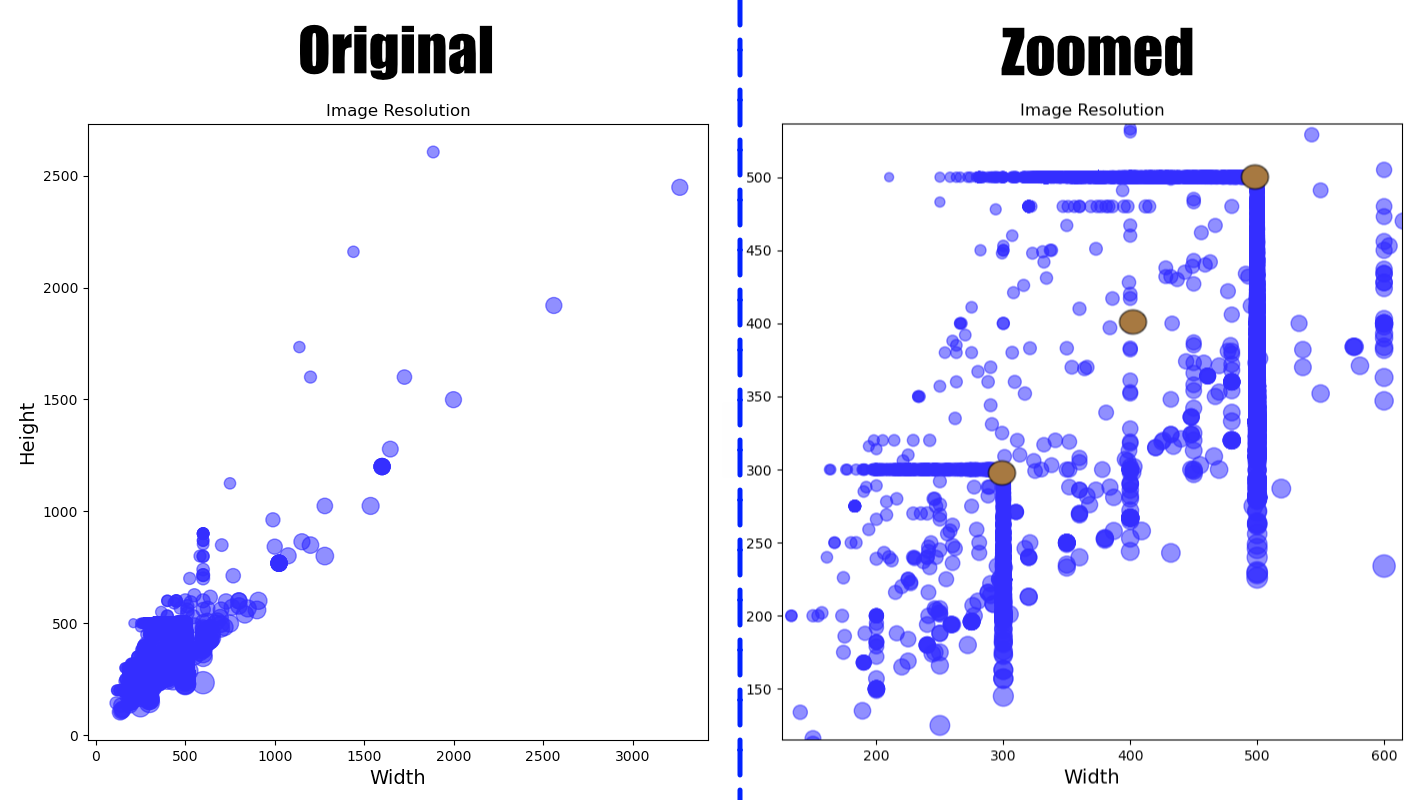

From the first plot it looks like most images are of resolution less than 500 by 500. After zooming in, we can clearly see that images are clustered around either size 300 or 500. My recommendation for this dataset is to start the training neural network with image size 300 and progressively increase it to 400 and finish it with size 500. By this way the model should be able to generalize well for different image resolutions.

## Bonus

1. Wouldn't it be great if we can see the underlying images while inspecting the points in the plot? This can help us to identify the following potential issues
* Mislabeled data: Can confuse the model.
* Certain class images are of very high or low resolution: Could make the model biased.

2. After inspection if we conclude that some data points should be removed, then use [Lasso Selector](https://matplotlib.org/stable/gallery/widgets/lasso_selector_demo_sgskip.html) to achieve that.

In [21]:
# Interactive Plotting

# Import libraries
from matplotlib.widgets import LassoSelector
from matplotlib.path import Path as mplPath

# Lasso Selection of data points
class SelectFromCollection:
	def __init__(self, ax, collection, alpha_other=0.3):
		self.canvas = ax.figure.canvas
		self.collection = collection

		self.xys = collection.get_offsets()
		self.lasso = LassoSelector(ax, onselect=self.onselect)
		self.ind = []

	def onselect(self, verts):
		path = mplPath(verts)
		self.ind = np.nonzero(path.contains_points(self.xys))[0]
		self.canvas.draw_idle()

	def disconnect(self):
		self.canvas.draw_idle()

# Show the original image upon picking the point
def on_pick(event):
	ind = event.ind[0]
	w, h = points.get_offsets().data[ind]
	img_file = Path(img_meta_df.iloc[ind, 0])
	if Path(root,img_file).is_file():
		print(f"Showing: {img_file}")
		img = Image.open(Path(root,img_file))
		figs = plt.figure(figsize=(5, 5))
		axs = figs.add_subplot(111)
		axs.set_title(Path(img_file).name, size=14)
		axs.set_xticks([])
		axs.set_yticks([])
		axs.set_xlabel(f'Dim: {round(w)} x {round(h)}', size=14)
		axs.imshow(img)
		figs.tight_layout()
		figs.show()

# Save selected image filenames  
def save_selected_imgs(df, fileName = Path("Images to discard.csv")):
	if fileName.is_file():
		orgData = pd.read_csv(fileName)
		df = pd.concat([orgData, df])
	df.set_axis(['FileName'], axis='columns').to_csv(fileName, index=False)

# Store selected points upon pressing "enter"
def accept(event):
	if event.key == "enter":
		selected_imgs = img_meta_df.iloc[selector.ind, 0].to_frame()
		save_selected_imgs(selected_imgs)
		print("Selected images:")
		print(selected_imgs)
		selector.disconnect()
		fig.canvas.draw()
        
# Plot the image resolutions        
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
points = ax.scatter(img_meta_df.Width, img_meta_df.Height, color='blue', alpha=0.5, s=img_meta_df["Aspect Ratio"]*100, picker=True)
ax.set_title("Press enter to after selecting the points.")
ax.set_xlabel("Width", size=14)
ax.set_ylabel("Height", size=14)

# Add interaction
selector = SelectFromCollection(ax, points)
fig.canvas.mpl_connect("key_press_event", accept)
fig.canvas.mpl_connect('pick_event', on_pick)
plt.show()

Showing: Egyptian_Mau_162.jpg
Selected images:
                  FileName
904   Egyptian_Mau_165.jpg
1394  Egyptian_Mau_162.jpg
Showing: Egyptian_Mau_182.jpg
Selected images:
                  FileName
6859  Egyptian_Mau_182.jpg
7263        Bombay_140.jpg


![Interactive Plot](https://github.com/6aravind/tidbits/blob/main/assets/gifs/Interactive%20Plot.gif?raw=true)